In [1]:
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost


2023-04-05 16:13:26.266829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np

In [3]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [4]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [5]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

23/04/05 16:13:38 WARN Utils: Your hostname, Roys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.172 instead (on interface en0)
23/04/05 16:13:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/05 16:13:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://project444.s3.us-west-1.amazonaws.com/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

In [7]:
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [8]:
pandasDF = df.toPandas()
pandasDF

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,Yes,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [9]:
pandasDF = pandasDF.astype({"id": int, "hypertension": int, "heart_disease": int, "stroke": int })

In [10]:
pandasDF = pandasDF.astype({'avg_glucose_level': float})

In [11]:
pandasDF['bmi'] = pandasDF['bmi'].str.replace('N/A','NaN')

In [12]:
pandasDF = pandasDF.astype({'bmi': float})

In [13]:
stroke_df = pandasDF

In [14]:
pd.set_option("display.max_rows", None)
stroke_df.head()
stroke_df.dtypes
stroke_df['bmi'] = stroke_df['bmi'].fillna(0)

In [15]:
stroke_df.isna().sum()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
stroke_df.nunique()


id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64

In [17]:
stroke_df.drop(columns='id', inplace=True)
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [18]:
df_dummies = pd.get_dummies(stroke_df[['gender','ever_married', 'work_type','Residence_type', 'smoking_status']])
stroke_df_copy = stroke_df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']]
merged_data = pd.concat([stroke_df_copy, df_dummies], axis= 1)
merged_data.head()
X = merged_data.drop('stroke', axis=1).values
y = merged_data['stroke'].values


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [20]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
len(X_train[0])

21

In [22]:
nn = tf.keras.models.Sequential()
number_of_input_features = len(X_train[0])
hidden_neuron1 = 100 
hidden_neuron2 = 50 
hidden_neuron3 = 30 

nn.add(tf.keras.layers.Dense(units = hidden_neuron1, activation='relu', input_dim = number_of_input_features))
nn.add(tf.keras.layers.Dense(units = hidden_neuron2, activation='sigmoid'))
nn.add(tf.keras.layers.Dense(units = hidden_neuron3, activation='sigmoid'))
nn.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,811
Trainable params: 8,811
Non-trainable params: 0
_________________________________________________________________


In [23]:
nn.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:
nn.fit(X_train_scaled, y_train, epochs = 100)

Epoch 1/100
120/120 [==============================] - 1s 1ms/step - loss: 0.4116 - accuracy: 0.8072
Epoch 2/100
120/120 [==============================] - 0s 958us/step - loss: 0.1864 - accuracy: 0.9559
Epoch 3/100
120/120 [==============================] - 0s 960us/step - loss: 0.1774 - accuracy: 0.9559
Epoch 4/100
120/120 [==============================] - 0s 953us/step - loss: 0.1710 - accuracy: 0.9559
Epoch 5/100
120/120 [==============================] - 0s 955us/step - loss: 0.1619 - accuracy: 0.9559
Epoch 6/100
120/120 [==============================] - 0s 941us/step - loss: 0.1551 - accuracy: 0.9559
Epoch 7/100
120/120 [==============================] - 0s 998us/step - loss: 0.1500 - accuracy: 0.9559
Epoch 8/100
120/120 [==============================] - 0s 941us/step - loss: 0.1462 - accuracy: 0.9559
Epoch 9/100
120/120 [==============================] - 0s 1ms/step - loss: 0.1435 - accuracy: 0.9559
Epoch 10/100
120/120 [==============================] - 0s 968us/step - loss:

In [25]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose =2)
print(f"Model_loss: {model_loss}, Model_accuracy: {model_accuracy}")

40/40 - 0s - loss: 0.2886 - accuracy: 0.9304 - 166ms/epoch - 4ms/step
Model_loss: 0.2886277437210083, Model_accuracy: 0.930359959602356


In [26]:
xgb_model = xgboost.XGBClassifier()
xgb_model = xgb_model.fit(X_train_scaled, y_train)
predictions = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9327073552425665

In [27]:
forest_model = RandomForestClassifier(n_estimators= 398, random_state= 42)
forest_model = forest_model.fit(X_train_scaled, y_train)
predictions1 = forest_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy 

0.9327073552425665

In [28]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[1185,   13],
       [  73,    7]])

In [29]:
## Classification Report
from sklearn.metrics import classification_report
target_names = ["0", "1"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1198
           1       0.35      0.09      0.14        80

    accuracy                           0.93      1278
   macro avg       0.65      0.54      0.55      1278
weighted avg       0.90      0.93      0.91      1278



In [30]:
# Random Forests in sklearn will automatically calculate feature importance
importances = forest_model.feature_importances_
# We can sort the features by their importance
features = merged_data.drop('stroke', axis=1)
sorted(zip(forest_model.feature_importances_, features.columns), reverse=True)

[(0.2555301727843203, 'avg_glucose_level'),
 (0.23735061132970622, 'age'),
 (0.22071457189583477, 'bmi'),
 (0.027891766926275298, 'hypertension'),
 (0.026707211695481785, 'heart_disease'),
 (0.02082551215118089, 'smoking_status_never smoked'),
 (0.020502583049011768, 'work_type_Private'),
 (0.019906146639983083, 'work_type_Self-employed'),
 (0.01988296365530764, 'gender_Female'),
 (0.019852275903664677, 'Residence_type_Urban'),
 (0.019692270650587113, 'gender_Male'),
 (0.018997089604537932, 'smoking_status_formerly smoked'),
 (0.018930864453701703, 'smoking_status_smokes'),
 (0.01892672662440686, 'Residence_type_Rural'),
 (0.017582253621402227, 'smoking_status_Unknown'),
 (0.013330040219789388, 'work_type_Govt_job'),
 (0.010968327055775112, 'ever_married_No'),
 (0.010950972325912014, 'ever_married_Yes'),
 (0.001445779478056669, 'work_type_children'),
 (1.1859935064607554e-05, 'work_type_Never_worked'),
 (0.0, 'gender_Other')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

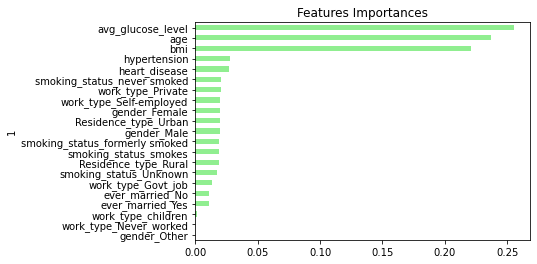

In [31]:
importances_df = pd.DataFrame(sorted(zip(forest_model.feature_importances_, features.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
#recall has been very low despite good precision

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
df_dummies = pd.get_dummies(stroke_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']])
X_new  = df_dummies
y_new = stroke_df['stroke']


X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, train_size=0.3, random_state=42)

In [36]:
rfc = RandomForestClassifier()

In [39]:
oversample = SMOTE()
X_train_resh_new, y_train_resh_new = oversample.fit_resample(X_train_new, y_train_new.ravel())

In [40]:
rfc.fit(X_train_resh_new,y_train_resh_new)

rfc_tuned_pred_new = rfc.predict(X_test_new)

In [41]:
print(classification_report(y_test_new,rfc_tuned_pred_new))

print('Accuracy Score: ',accuracy_score(y_test_new,rfc_tuned_pred_new))
print('F1 Score: ',f1_score(y_test_new,rfc_tuned_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3404
           1       0.11      0.10      0.11       173

    accuracy                           0.92      3577
   macro avg       0.53      0.53      0.53      3577
weighted avg       0.91      0.92      0.91      3577

Accuracy Score:  0.9161308358960022
F1 Score:  0.10714285714285715


In [37]:
rfc.fit(X_train_new,y_train_new)

rfc_tuned_pred_new = rfc.predict(X_test_new)

In [38]:
print(classification_report(y_test_new,rfc_tuned_pred_new))

print('Accuracy Score: ',accuracy_score(y_test_new,rfc_tuned_pred_new))
print('F1 Score: ',f1_score(y_test_new,rfc_tuned_pred_new))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3404
           1       0.20      0.01      0.02       173

    accuracy                           0.95      3577
   macro avg       0.58      0.50      0.50      3577
weighted avg       0.92      0.95      0.93      3577

Accuracy Score:  0.949958065417948
F1 Score:  0.02185792349726776


In [43]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
#logistic regression basic

In [44]:
logistic_regression_model = LogisticRegression(random_state=9)

In [46]:
lr_model = logistic_regression_model.fit(X_train_resh_new,y_train_resh_new)
lr_pred   = logistic_regression_model.predict(X_test_new)

/Users/royjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
print(classification_report(y_test_new,lr_pred))

print('Accuracy Score: ',accuracy_score(y_test_new,lr_pred))
print('F1 Score: ',f1_score(y_test_new,lr_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3404
           1       0.22      0.17      0.19       173

    accuracy                           0.93      3577
   macro avg       0.59      0.57      0.58      3577
weighted avg       0.92      0.93      0.93      3577

Accuracy Score:  0.9315068493150684
F1 Score:  0.19141914191419143


In [ ]:
#logistic regression solver 'lbfgs'

In [48]:
classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Define the logistic regression model
log_classifier = LogisticRegression(solver="lbfgs",max_iter=200)

# Train the model
log_classifier.fit(X_train_resh_new,y_train_resh_new)

/Users/royjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [49]:
lr_pred_2 = log_classifier.predict(X_test_new)

In [50]:
print(classification_report(y_test_new,lr_pred_2))

print('Accuracy Score: ',accuracy_score(y_test_new,lr_pred_2))
print('F1 Score: ',f1_score(y_test_new,lr_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3404
           1       0.25      0.12      0.16       173

    accuracy                           0.94      3577
   macro avg       0.60      0.55      0.56      3577
weighted avg       0.92      0.94      0.93      3577

Accuracy Score:  0.9404528934861616
F1 Score:  0.15810276679841898


In [ ]:
#logistic regression grid search

In [62]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 
#C = np.logspace(-4, 4, 20)

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression()
grid = GridSearchCV(logreg,log_param_grid)

In [63]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh_new,y_train_resh_new)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(X_test_new)

In [64]:
print(classification_report(y_test_new,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_new,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test_new,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3404
           1       0.23      0.04      0.07       173

    accuracy                           0.95      3577
   macro avg       0.59      0.52      0.52      3577
weighted avg       0.92      0.95      0.93      3577

Accuracy Score:  0.9471624266144814
F1 Score:  0.06896551724137931


In [54]:
from sklearn.svm import SVC

In [58]:
model = SVC(kernel='linear')
model.fit(X_train_resh_new,y_train_resh_new)
pred   = model.predict(X_test_new)

In [59]:
print(classification_report(y_test_new,pred))

print('Accuracy Score: ',accuracy_score(y_test_new,pred))
print('F1 Score: ',f1_score(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3404
           1       0.17      0.05      0.07       173

    accuracy                           0.94      3577
   macro avg       0.56      0.52      0.52      3577
weighted avg       0.92      0.94      0.93      3577

Accuracy Score:  0.9432485322896281
F1 Score:  0.0730593607305936


In [60]:
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(C=100,gamma=0.1,kernel='rbf',random_state=42))])

svm_pipeline.fit(X_train_resh_new,y_train_resh_new)

svm_tuned_pred   = svm_pipeline.predict(X_test_new)

In [61]:
print(classification_report(y_test_new,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_new,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test_new,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3404
           1       0.12      0.10      0.11       173

    accuracy                           0.92      3577
   macro avg       0.54      0.53      0.53      3577
weighted avg       0.91      0.92      0.92      3577

Accuracy Score:  0.9203242941012021
F1 Score:  0.10658307210031348
